<a href="https://colab.research.google.com/github/FatimaPassos1986/TFM/blob/master/run_melanoma_detection_(Segundo_Scenario).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Lesion Classification to Cancer Melanoma Detection
# (SECOND SCENARIO): 

*Due in first scenario we didn't reach the predictions on validation set because the memory of system fails, we make an another experiment using a more simple model to train, for this scenario we use a Sequential Model. In addition we:
*

1.   *Reduce the images even more to (100 x 75 x 3)*
2.   *Not apply augmentation *
and..
3.   *Split the train dataset 75%-25% *



## Input Data:
We upload a new version 2 of file: "ISIC2018_Task3_Training_GroundTruth_prueba2.xls" (in excel format). We create some new columns (path to image, code).

## Uploading data

The files of interest belong to task 3 of ISIC2018 Challenge, and they were uploaded to my Google Drive account. They're available to download on ISIC2018 web too: (https://challenge2018.isic-archive.com/task3/)

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz

In [66]:
!pip install scikit-image
!pip install keras

In [3]:
!ls

adc.json  sample_data


In [0]:
##TASK 3_Uploading Images for Train and Ground Truth:

file_id = '1LSrdLKlX7xuFpfMt6jagmQR17iBGSijy'     
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("ISIC2018_Task3_Training_Input.zip")   ## 10015 imagenes .jpg

file_id = '1VaXSolajW_6flYdvy6OF7Bl8yG0_j-uG'                
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("ISIC2018_Task3_Training_GroundTruth.zip")

file_id = '1WTEsLRhiWSYk4VG5WCbZRKtT1ljJg4vl'                
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("ISIC2018_Task3_Training_GroundTruth_prueba2.xls")  


In [0]:
!ls

## Data preparation:

To place the unzipped ISIC 2018 data, I created a folder "datasets/ISIC2018/data", including the following subfolders:

    ISIC2018_Task3_Training_GroundTruth
       ISIC2018_Task3_Training_GroundTruth_prueba2.xls 
    ISIC2018_Task3_Training_Input


In [0]:
mkdir datasets

In [0]:
!cd '/content/datasets/' && mkdir ISIC2018

In [9]:
!find '/content/datasets'

/content/datasets
/content/datasets/ISIC2018


In [0]:
import os, shutil
base_dir = "/content/datasets/ISIC2018"
data_dir = os.path.join(base_dir, "data")


In [0]:
os.mkdir(data_dir)

In [11]:
pwd

'/content'

In [0]:
!find '/content'

In [0]:
task3_img = 'ISIC2018_Task3_Training_Input'

task3_gt = 'ISIC2018_Task3_Training_GroundTruth_prueba2'  

In [0]:
task3_img_dir = os.path.join(data_dir, task3_img)

task3_gt_dir = os.path.join(data_dir, task3_gt)

In [15]:
##Moving and Unzipping the Images:

import shutil

shutil.move('ISIC2018_Task3_Training_Input.zip', '/content/datasets/ISIC2018/data/')
shutil.move('ISIC2018_Task3_Training_GroundTruth.zip', '/content/datasets/ISIC2018/data/')

'/content/datasets/ISIC2018/data/ISIC2018_Task3_Training_GroundTruth.zip'

In [0]:

!cd '/content/datasets/ISIC2018/data/' && unzip -q 'ISIC2018_Task3_Training_Input.zip'
!cd '/content/datasets/ISIC2018/data/' && unzip -q 'ISIC2018_Task3_Training_GroundTruth.zip'

!ls -hl '/content/datasets/ISIC2018/data/'

In [18]:
import shutil
shutil.move('ISIC2018_Task3_Training_GroundTruth_prueba2.xls', '/content/datasets/ISIC2018/data/ISIC2018_Task3_Training_GroundTruth/')

'/content/datasets/ISIC2018/data/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth_prueba2.xls'

In [0]:
!find '/content'

##Initialization

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil, glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from tqdm import tqdm
from skimage import io
from skimage import transform

from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K


Using TensorFlow backend.


In [0]:
# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [22]:
!pip install xlrd

    100% |████████████████████████████████| 112kB 3.0MB/s 


In [23]:
# Read the xls file

file = pd.read_excel('/content/datasets/ISIC2018/data/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth_prueba2.xls')
tile_df = pd.DataFrame(file)
tile_df.head(10)

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,code,path
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Melanocytic nevus,/content/datasets/ISIC2018/data/ISIC2018_Task3...
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Melanocytic nevus,/content/datasets/ISIC2018/data/ISIC2018_Task3...
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Melanocytic nevus,/content/datasets/ISIC2018/data/ISIC2018_Task3...
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Melanocytic nevus,/content/datasets/ISIC2018/data/ISIC2018_Task3...
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Melanoma,/content/datasets/ISIC2018/data/ISIC2018_Task3...
5,ISIC_0024311,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Melanocytic nevus,/content/datasets/ISIC2018/data/ISIC2018_Task3...
6,ISIC_0024312,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Benign keratosis,/content/datasets/ISIC2018/data/ISIC2018_Task3...
7,ISIC_0024313,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Melanoma,/content/datasets/ISIC2018/data/ISIC2018_Task3...
8,ISIC_0024314,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Melanocytic nevus,/content/datasets/ISIC2018/data/ISIC2018_Task3...
9,ISIC_0024315,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Melanoma,/content/datasets/ISIC2018/data/ISIC2018_Task3...


In [24]:
tile_df['cell_type_idx'] = pd.Categorical(tile_df['code']).codes
tile_df.sample(5)

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,code,path,cell_type_idx
9725,ISIC_0034031,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Benign keratosis,/content/datasets/ISIC2018/data/ISIC2018_Task3...,2
6059,ISIC_0030365,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Benign keratosis,/content/datasets/ISIC2018/data/ISIC2018_Task3...,2
4540,ISIC_0028846,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Benign keratosis,/content/datasets/ISIC2018/data/ISIC2018_Task3...,2
3817,ISIC_0028123,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Benign keratosis,/content/datasets/ISIC2018/data/ISIC2018_Task3...,2
7914,ISIC_0032220,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Melanoma,/content/datasets/ISIC2018/data/ISIC2018_Task3...,5


In [0]:
##### no ejecutado a ver que pasa....CREO QUE NO ES NECESARIO:


MEL = 0  # Melanoma
NV = 1  # Melanocytic nevus
BCC = 2  # Basal cell carcinoma
AKIEC = 3  # Actinic keratosis / Bowen's disease (intraepithelial carcinoma)
BKL = 4  # Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
DF = 5  # Dermatofibroma
VASC = 6  # Vascular lesion


classes = [MEL, NV, BCC, AKIEC, BKL, DF, VASC]
class_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']


def load_task3_training_labels():
    # image, MEL, NV, BCC, AKIEC, BKL, DF, VASC
    labels = []
    with open(os.path.join(task3_gt_dir, task3_gt_fname), 'r') as f:
        for i, line in tqdm(enumerate(f.readlines()[1:])):
            fields = line.strip().split(',')
            labels.append([eval(field) for field in fields[1:]])
        labels = np.stack(labels, axis=0)
    return labels


## Exploratory Data Analysis


In [28]:
# Get general statistics for the dataset

tile_df.describe(exclude=[np.number])

,image,code,path
count,5015,5015,5015
unique,5015,7,5015
top,ISIC_0033680,Melanocytic nevus,/content/datasets/ISIC2018/data/ISIC2018_Task3...
freq,1,1705,1


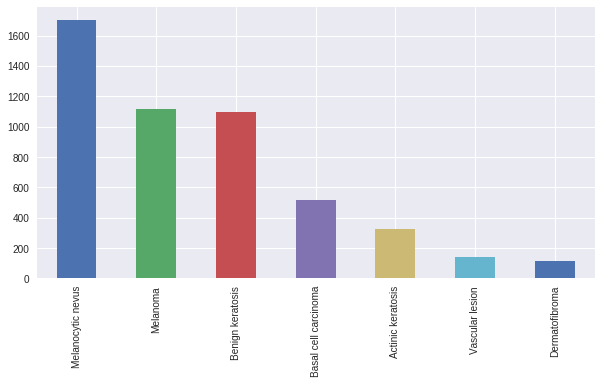

In [29]:
# Let's see the distribution of different cell types

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
tile_df['code'].value_counts().plot(kind='bar', ax=ax1)

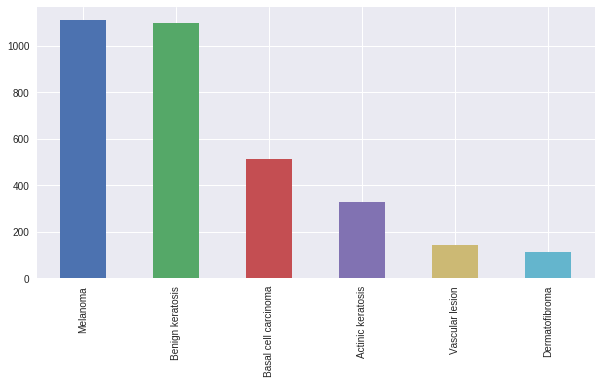

In [30]:
# Too many melanocytic nevi - let's balance it a bit!

tile_df = tile_df.drop(tile_df[tile_df.code == 'Melanocytic nevus'].iloc[:5000].index)

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
tile_df['code'].value_counts().plot(kind='bar', ax=ax1)

## Import and resize images


In [0]:
# Load in all of the images into memory - this will take a while.  
# We also do a resize step because the original dimensions of 450 * 600 * 3 was too much for TensorFlow

tile_df['image_resized'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))



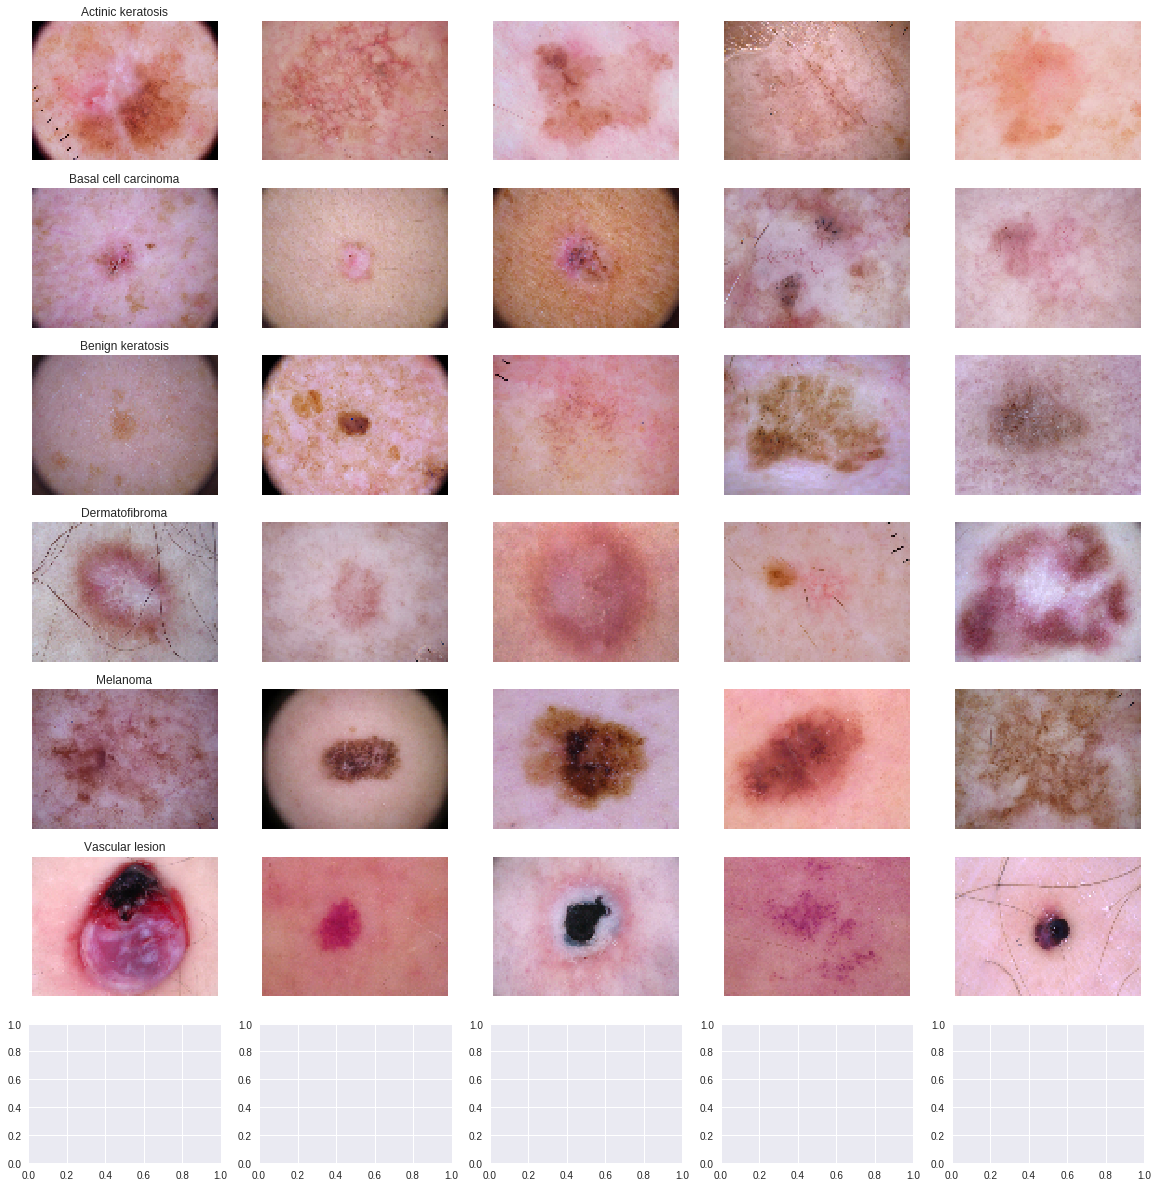

In [32]:
# verifiying if the images are resized:

n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         tile_df.sort_values(['code']).groupby('code')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image_resized'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [33]:
# See the image size distribution - should just return one row (all images are uniform)
tile_df['image_resized'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    3310
Name: image_resized, dtype: int64

###Color channel analysis

How do the normalized color samples vary across different types of skin diseases?


In [34]:
rgb_info_df = tile_df.apply(lambda x: pd.Series({'{}_mean'.format(k): v for k, v in 
                                  zip(['Red', 'Green', 'Blue'], 
                                      np.mean(x['image_resized'], (0, 1)))}),1)
gray_col_vec = rgb_info_df.apply(lambda x: np.mean(x), 1)
for c_col in rgb_info_df.columns:
    rgb_info_df[c_col] = rgb_info_df[c_col]/gray_col_vec
rgb_info_df['Gray_mean'] = gray_col_vec
rgb_info_df.sample(10)


,Blue_mean,Green_mean,Red_mean,Gray_mean
61,0.963400,0.913869,1.122731,167.513778
5470,1.010675,0.918917,1.070407,151.213600
799,0.888015,0.883893,1.228091,157.550267
1237,0.954828,0.887955,1.157216,144.082178
9150,0.939710,0.853971,1.206319,150.891378
455,1.037304,0.931590,1.031106,148.657422
5499,0.933347,0.903449,1.163204,163.438667
7974,0.968281,0.939211,1.092507,143.445067
233,0.967413,0.837336,1.195251,177.956178
369,1.040558,0.893850,1.065592,175.014622


In [0]:
for c_col in rgb_info_df.columns:
    tile_df[c_col] = rgb_info_df[c_col].values

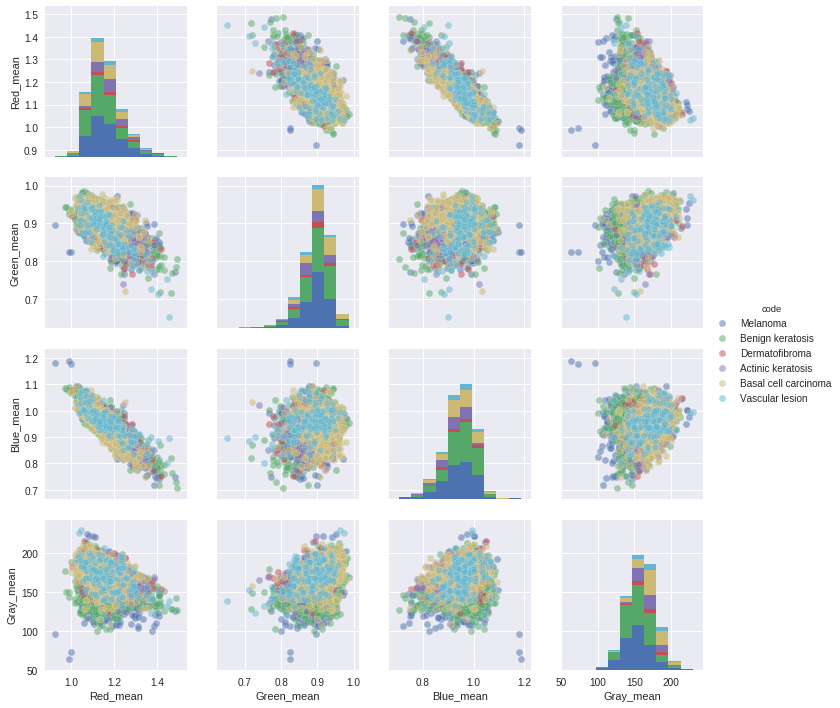

In [36]:
sns.pairplot(tile_df[['Red_mean', 'Green_mean', 'Blue_mean', 'Gray_mean', 'code']], 
             hue='code', plot_kws = {'alpha': 0.5})


## Deep Convolutional Classifier

**Create a new training and test sets:**


In [0]:
y = tile_df.cell_type_idx

from sklearn.model_selection import train_test_split
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(tile_df, y, test_size=0.25)

x_train = np.asarray(x_train_o['image_resized'].tolist())
x_test = np.asarray(x_test_o['image_resized'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

**We are going to build a multi-class classifier using a deep convolutional network architecture:**

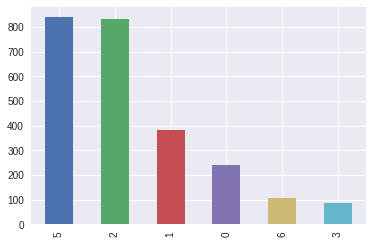

In [38]:
y_train_o.value_counts().plot(kind='bar')


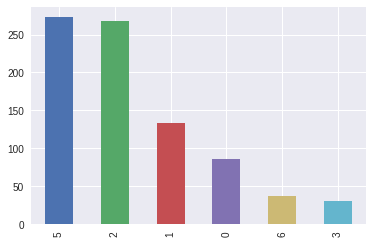

In [39]:
y_test_o.value_counts().plot(kind='bar')


**Define our deep convolutional network architecture:**

In [0]:
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [0]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])


**Train the model...**

In [42]:
batch_size = 32 
epochs = 12

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 2482 samples, validate on 828 samples
Epoch 1/12
2482/2482 [==============================] - 11s 4ms/step - loss: 1.6593 - acc: 0.4061 - val_loss: 1.4593 - val_acc: 0.4191
Epoch 2/12
2482/2482 [==============================] - 5s 2ms/step - loss: 1.2425 - acc: 0.4952 - val_loss: 1.3824 - val_acc: 0.4384
Epoch 3/12
2482/2482 [==============================] - 5s 2ms/step - loss: 1.1024 - acc: 0.5576 - val_loss: 1.1846 - val_acc: 0.5254
Epoch 4/12
2482/2482 [==============================] - 5s 2ms/step - loss: 0.9696 - acc: 0.6189 - val_loss: 1.3402 - val_acc: 0.4891
Epoch 5/12
2482/2482 [==============================] - 5s 2ms/step - loss: 0.8033 - acc: 0.6926 - val_loss: 1.2351 - val_acc: 0.5121
Epoch 6/12
2482/2482 [==============================] - 6s 2ms/step - loss: 0.6301 - acc: 0.7623 - val_loss: 1.1073 - val_acc: 0.5761
Epoch 7/12
2482/2482 [==============================] - 5s 2ms/step - loss: 0.4739 - acc: 0.8304 - val_loss: 1.2292 - val_acc: 0.5761
Epoch 8/12
248


## Model Validation

Loss and accuracy curves for training and test sets.


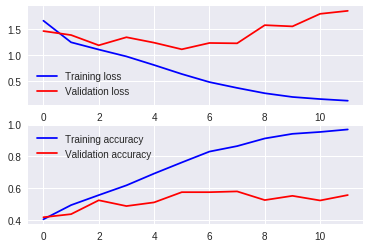

In [48]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

**we experiment with different # epochs but the best values for loss and accuracy were obtained for epochs =12**

##Confusion matrix:

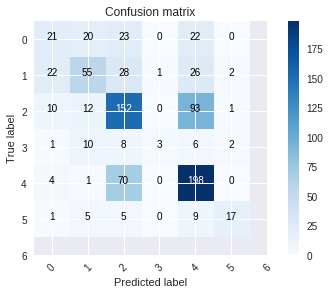

In [64]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

## Results and conclusions (Second and final scenario)

* Despite reducing the data load to the model, it was observed that the values ​​obtained for LOSS = 1.84 and ACC = 55% were much lower than those obtained using the configuration of the first scenario. However, if we achieved that the system did not produce the memory failure and restart before the end of the training.

*  It was also observed that the Sequencial model is acceptable but not the most appropriate to handle a large number of images. Models like Resnet50 (used in scenario 1) or InceptionV3 work best.

* For this type of project, it is best to use several GPUs in parallel or a similar platform.





